# Neural Network Regression: Laptop Prices prediction

In this notebook, I am practicing neural network regression with TensorFlow. I am using the [laptop_price dataset](https://www.kaggle.com/datasets/muhammetvarl/laptop-price?resource=download) from Kaggle. <br><br>
GOAL: practice neural network regression with TensorFlow and minimise the error when predicting laptop prices.
<br><br>
Concepts practiced: One hot encoding, feature scaling, feature engineering, supervised learning

## Importing libraries

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Data cleaning & feature engineering

In [ ]:
laptop = pd.read_csv("/content/laptop_price.csv", encoding='latin-1')

In [ ]:
laptop.head(6)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
5,6,Acer,Aspire 3,Notebook,15.6,1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows 10,2.1kg,400.00


### General Cleaning: weight, ram columns and lower case conversion

From the dataframe above we can see that we have 13 columns describing an item (latop). We also see that some columns contain strings, some floats, and there are other columns such as weight and ram that are expressed as both strings and numbers. Ram and weight columns provide useful numerical information, while "kg" and "GB" are implied and do not add any important insight, so I will remove them. I will also remove product_id column since the dataframe is already indexed. I will also convert all strings to lower case to reduce inaccuracy, and clean "messier" columns individually by separating them into several columns. <br><br>

In [ ]:
# converting to lower case
laptop["Company"] = laptop["Company"].str.lower()
laptop["TypeName"] = laptop["TypeName"].str.lower()
laptop["ScreenResolution"], laptop["Cpu"], laptop["Memory"] = laptop["ScreenResolution"].str.lower(), laptop["Cpu"].str.lower(), laptop["Memory"].str.lower()
laptop["Gpu"], laptop["OpSys"] = laptop["Gpu"].str.lower(), laptop["OpSys"].str.lower()
laptop["Product"] = laptop["Product"].str.lower()

# getting rid of GB and kg in ram and weight columns
laptop["Ram"] = laptop["Ram"].str.replace("GB", "")
laptop["Weight"] = laptop["Weight"].str.replace("kg", '')

# converting weight and ram to numeric
laptop[["Ram", "Weight"]] = laptop[["Ram", "Weight"]].apply(pd.to_numeric)
laptop = laptop.drop(["laptop_ID"], axis = 1)


In [ ]:
laptop.head(6)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,apple,macbook pro,ultrabook,13.3,ips panel retina display 2560x1600,intel core i5 2.3ghz,8,128gb ssd,intel iris plus graphics 640,macos,1.37,1339.69
1,apple,macbook air,ultrabook,13.3,1440x900,intel core i5 1.8ghz,8,128gb flash storage,intel hd graphics 6000,macos,1.34,898.94
2,hp,250 g6,notebook,15.6,full hd 1920x1080,intel core i5 7200u 2.5ghz,8,256gb ssd,intel hd graphics 620,no os,1.86,575.00
3,apple,macbook pro,ultrabook,15.4,ips panel retina display 2880x1800,intel core i7 2.7ghz,16,512gb ssd,amd radeon pro 455,macos,1.83,2537.45
4,apple,macbook pro,ultrabook,13.3,ips panel retina display 2560x1600,intel core i5 3.1ghz,8,256gb ssd,intel iris plus graphics 650,macos,1.37,1803.60
5,acer,aspire 3,notebook,15.6,1366x768,amd a9-series 9420 3ghz,4,500gb hdd,amd radeon r5,windows 10,2.10,400.00


Now it is time to deal with the messier columns ("ScreenREsolution", "Cpu", "Memory" and "Gpu").

## Feature Engineering: screen resolution, cpu, and memory columns

### Screen Resolution: type, resolution, and touchscreen

In [ ]:
# Extracting the "digits x digits" pattern from the column
laptop["Resolution"] = laptop["ScreenResolution"].str.extract('(\d+x\d+)')
laptop["Screen type"] = laptop["ScreenResolution"].replace("(\d+x\d+)",'', regex = True)

# Full HD, etc is not significant since screen resolution of laptops is mentioned afterwards
# so it provides excessive and repetetive informatio
laptop["Screen type"] = laptop["Screen type"].replace('(full hd|quad hd|quad hd|\+|/|4k ultra hd)', '', regex = True)

# Creating a touchscreen column
laptop["Touchscreen"] = laptop["Screen type"].str.extract('(touchscreen)')
laptop["Screen type"] = laptop["Screen type"].replace('(touchscreen)', '', regex = True)

laptop = laptop.drop(["ScreenResolution"], axis = 1)

*Touch screen*: <br> One important piece of information that I noticed in the original column "ScreenResolution" was whether or not a laptop had touchscreen. Touchscreen might influence the laptop price, therefore, I am creating a new column to store which laptops have touchscreen.

**Screen Type**

The screen type column was still a little messy with extra spacings between words and empty values.

In [ ]:
# getting rid of extra spaces
laptop["Screen type"] = laptop["Screen type"].replace(" ", '', regex = True)
# replacing the empty values with Nans
laptop["Screen type"] = laptop["Screen type"].replace("^\s*$", np.nan, regex = True)

In [ ]:
laptop["Screen type"].value_counts()

ipspanel                 348
ipspanelretinadisplay     17
Name: Screen type, dtype: int64

### CPU: speed and type

The "Cpu" column below includes both the producer of the chip and its clock speed. We can separate those into two corresponding columns.

In [ ]:
laptop["Cpu speed"] = laptop["Cpu"].str.extract('(\d+(?:\.\d+)?ghz)')
laptop["Cpu speed"] = laptop["Cpu speed"].str.replace("ghz", '')
laptop["Cpu speed"] = laptop["Cpu speed"].astype(float)

In [ ]:
laptop["Cpu"] = laptop["Cpu"].replace('(\d+(?:\.\d+)?ghz)', '', regex =True)
laptop.rename(columns = {"Cpu": "Cpu type"}, inplace = True)

In [ ]:
laptop["Cpu type"] = laptop["Cpu type"].str.extract('^(\w+)')

In [ ]:
laptop["Cpu type"].value_counts()

intel      1240
amd          62
samsung       1
Name: Cpu type, dtype: int64

### Memory: type, amount of storage and second drive

In [ ]:
# Extracting all the information after + and storing in Memory2 column
laptop["Memory2"] = laptop["Memory"].str.extract("(\+.*)")
laptop["Memory2"] = laptop["Memory2"].str.replace("\+  ", "", regex = True)
#laptop[["Memory1", "Memory2"]] = laptop["Memory"].str.split("+.*") # (?<=+).*

In [ ]:
# Getting rid of all the information about the second drive from the original column
laptop["Memory"] = laptop["Memory"].str.replace("(\+.*)", "", regex = True)
laptop.rename(columns = {"Memory": "Memory1"}, inplace = True)

In [ ]:
# Converting tb to gb
laptop["Memory1"] = laptop["Memory1"].str.replace("1tb", "1000",regex = True)
laptop["Memory1"] = laptop["Memory1"].str.replace("1.0tb", "1000",regex = True)
laptop["Memory1"] = laptop["Memory1"].str.replace("2tb", "2000",regex = True)

laptop["Memory2"] = laptop["Memory2"].str.replace("1tb", "1000",regex = True)
laptop["Memory2"] = laptop["Memory2"].str.replace("1.0tb", "1000",regex = True)
laptop["Memory2"] = laptop["Memory2"].str.replace("2tb", "2000",regex = True)

In [ ]:
# Getting rid of gb
laptop["Memory1"] = laptop["Memory1"].str.replace("gb", "",regex = True)
laptop["Memory2"] = laptop["Memory2"].str.replace("gb", "",regex = True)

In [ ]:
# Extracting all the numbers from the memory columns and storing
# in size column
laptop["Memory2 size"] = laptop["Memory2"].str.extract("(\d+)")
laptop["Memory1 size"] = laptop["Memory1"].str.extract("(\d+)")

In [ ]:
# Removing all the digits from the memory columns
laptop["Memory2"] = laptop["Memory2"].str.replace("(\d+)", "", regex = True)
laptop["Memory1"] = laptop["Memory1"].str.replace("(\d+)", "", regex = True)
laptop.rename(columns = {"Memory2": "Memory2 type", "Memory1": "Memory1 type"}, inplace = True)

### GPU:

In [ ]:
laptop["Gpu"] = laptop["Gpu"].str.extract('^(\w+)')
laptop.rename(columns = {"Gpu":"Gpu type"}, inplace = True)

In [ ]:
# checking the dataframe datatypes
laptop.dtypes

Company          object
Product          object
TypeName         object
Inches          float64
Cpu type         object
Ram               int64
Memory1 type     object
Gpu type         object
OpSys            object
Weight          float64
Price_euros     float64
Resolution       object
Screen type      object
Touchscreen      object
Cpu speed       float64
Memory2 type     object
Memory2 size    float64
Memory1 size    float64
dtype: object

In [ ]:
laptop["Memory2 size"] = laptop["Memory2 size"].astype(float)
laptop["Memory1 size"] = laptop["Memory1 size"].astype(float)

This is the final dataset, I am saving it to my laptop so that I can upload this version of dataset to colab.

In [ ]:
laptop.head(6)

,Company,Product,TypeName,Inches,Cpu type,Ram,Memory1 type,Gpu type,OpSys,Weight,Price_euros,Resolution,Screen type,Touchscreen,Cpu speed,Memory2 type,Memory2 size,Memory1 size
0,apple,macbook pro,ultrabook,13.3,intel,8,ssd,intel,macos,1.37,1339.69,2560x1600,ipspanelretinadisplay,NaN,2.3,NaN,NaN,128
1,apple,macbook air,ultrabook,13.3,intel,8,flash storage,intel,macos,1.34,898.94,1440x900,NaN,NaN,1.8,NaN,NaN,128
2,hp,250 g6,notebook,15.6,intel,8,ssd,intel,no os,1.86,575.00,1920x1080,NaN,NaN,2.5,NaN,NaN,256
3,apple,macbook pro,ultrabook,15.4,intel,16,ssd,amd,macos,1.83,2537.45,2880x1800,ipspanelretinadisplay,NaN,2.7,NaN,NaN,512
4,apple,macbook pro,ultrabook,13.3,intel,8,ssd,intel,macos,1.37,1803.60,2560x1600,ipspanelretinadisplay,NaN,3.1,NaN,NaN,256
5,acer,aspire 3,notebook,15.6,amd,4,hdd,amd,windows 10,2.10,400.00,1366x768,NaN,NaN,3.0,NaN,NaN,500


In [ ]:
laptop.to_csv('laptop_prices_clean.csv', encoding='utf-8')

In [ ]:
laptop["Cpu speed"].value_counts()

2.50    293
2.70    166
2.80    165
1.60    134
2.30     86
2.00     86
1.80     78
2.60     76
1.10     53
2.40     52
2.90     21
3.00     19
1.20     15
1.44     12
2.20     11
1.50     10
1.30      6
3.60      5
0.90      4
3.10      3
2.10      3
1.90      2
3.20      1
1.00      1
1.92      1
Name: Cpu speed, dtype: int64

## EDA

### Price distributions in the dataset

In [3]:
laptop = pd.read_csv("/content/laptop_prices_clean.csv", encoding = "latin-1", index_col=0)

[]

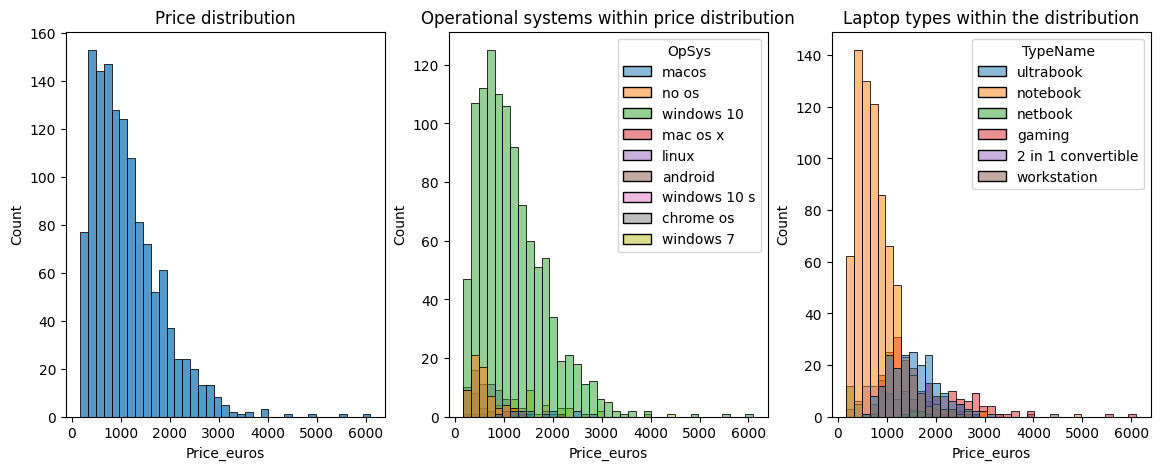

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(14,5))
sns.histplot(data=laptop, x="Price_euros", ax = axes[0]).set_title("Price distribution")
sns.histplot(data=laptop, x="Price_euros", hue = "OpSys", ax = axes[1]).set_title("Operational systems within price distribution")
sns.histplot(data = laptop, x = "Price_euros", hue = "TypeName", ax = axes[2]).set_title("Laptop types within the distribution")
plt.plot()

We can see that the price distribution is right-skewed, meaning that laptops with prices 3000-6000 are less frequent than the ones with 0-3000 in teh dataset. <br><br>
On the second histogram one can see that laptops with no os operational system have price of roughly 0-1200 euros, while windows 10 laptops span the full range of prices from 0 to 6000 euros. <br><br>
On the third histogram we see that notebooks presented in this dataset cost 0-3000, while gaming laptops range from 1000 to 6000.

### Weight distribution

[]

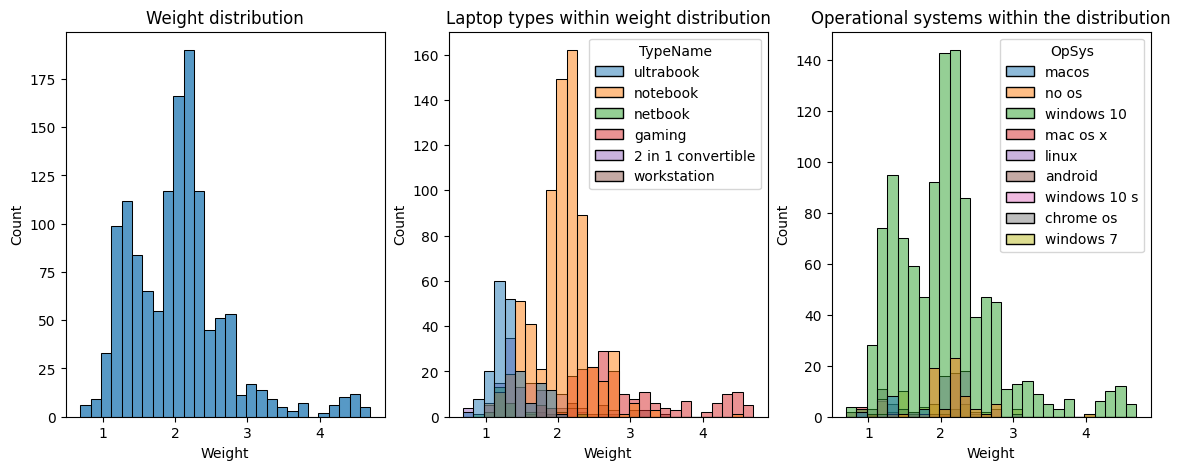

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(14,5))
sns.histplot(data=laptop, x="Weight", ax = axes[0]).set_title("Weight distribution")
sns.histplot(data=laptop, x="Weight", hue = "TypeName", ax = axes[1]).set_title("Laptop types within weight distribution")
sns.histplot(data = laptop, x = "Weight", hue = "OpSys", ax = axes[2]).set_title("Operational systems within the distribution")
plt.plot()

The weight distribution is slightly skewed to the right, meaning that most laptops in the dataset fall in between 0-2.5 kg range. <br><br>
On the second histogram we can see that the mode weight within notebook type of laptops falls at around 2.2 kg, while the mode weight for ultrabooks is ~ 1.2 kg. Gaming laptops within the dataset most frequently weigh ~ 2.6 kg. These laptops also represent the heaviest subgroup, they can weigh up to 4.8 kg. <br><br>
The third dataset shows that laptops with macos and no os operational systems have a much narrower distribution that laptops with windows operational system in the given dataset. Macos laptops range from 0.8 - 1.8 kg, no os laptops 1.7 - 2.9 kg, while windows 10 laptops range from 0.5 kg to ~ 4.8 kg. So, we can deduce that the gaming laptops in our dataset most likely have windows 10 operational system, and they are also the most expensive ones!

### Barplots: Company, laptop type, operational system, resolution

Text(0.5, 1.0, 'Resolution frequency')

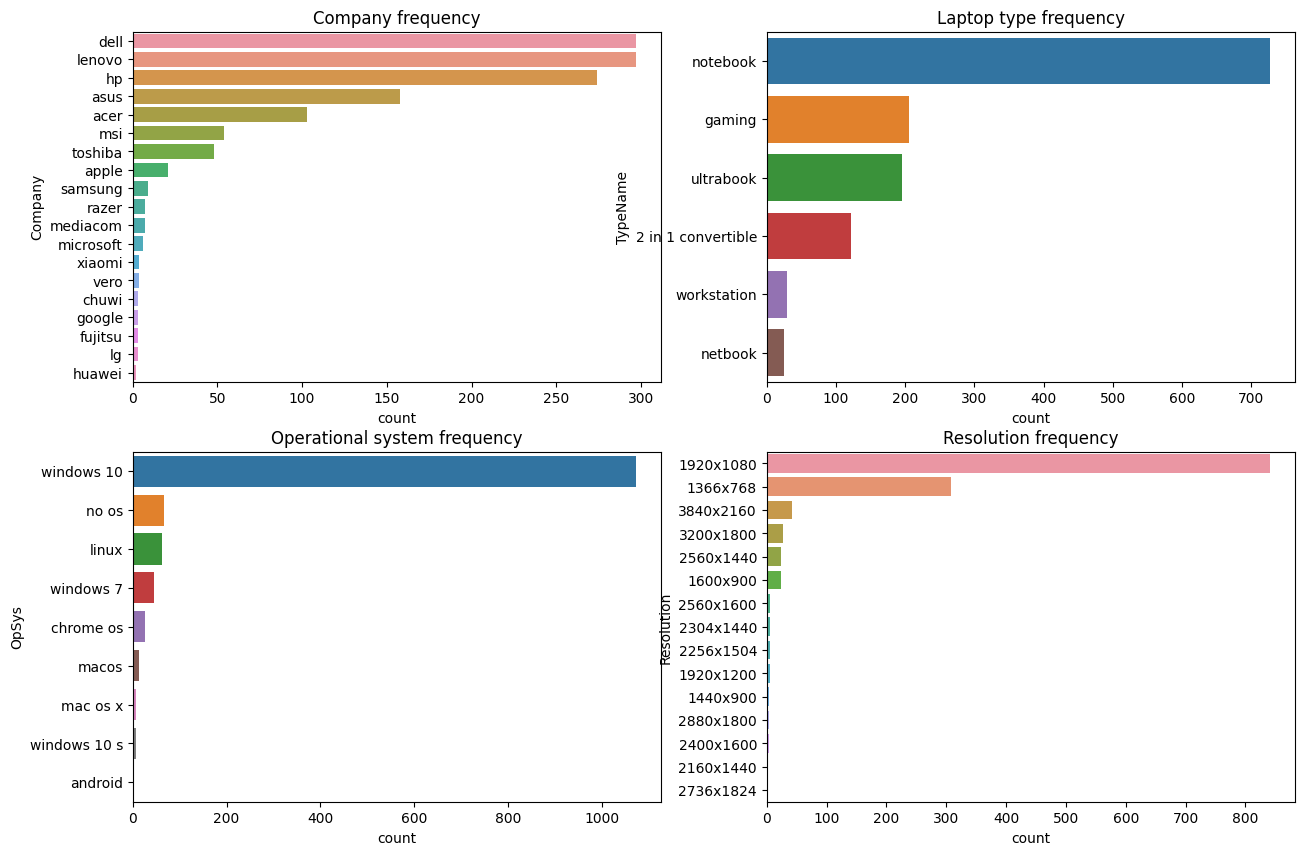

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15,10), sharex=False)

sns.countplot(data=laptop,y="Company", ax = axes[0,0], order=laptop['Company'].value_counts().index).set_title("Company frequency")
sns.countplot(data=laptop,y="TypeName", ax = axes[0,1], order=laptop['TypeName'].value_counts().index).set_title("Laptop type frequency")
sns.countplot(data=laptop,y="OpSys", ax = axes[1, 0], order=laptop['OpSys'].value_counts().index).set_title("Operational system frequency")
sns.countplot(data=laptop,y="Resolution", ax = axes[1, 1], order=laptop['Resolution'].value_counts().index).set_title("Resolution frequency")

The first bar plot shows that the three most frequent companies represented in the dataset are dell, lenovo and hp. the most represented type of laptop is notebook, and the most represented operational system is windows 10, which explains the wide range of weight and price laptops with this operational system have. The most common resolution frequency in the dataset is full hd (1920x1080).

### Scatter plots

Text(0.5, 1.0, 'Weight vs Inches with Price')

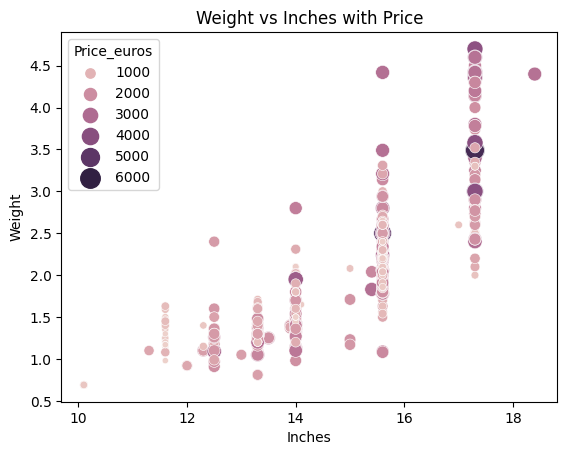

In [ ]:
sns.scatterplot(data = laptop, x = "Inches", y = "Weight", hue = "Price_euros", size = "Price_euros", sizes=(20, 200)).set_title("Weight vs Inches with Price")

We can see a generally upwords trend on the graph, sugggesting that as inches increase, the laptop's weight also tends to increase. We can also see that prices tend to increase from ~1000 euros to ~ 5000 as we move to the upper right corner of the plot.

<Figure size 640x480 with 0 Axes>

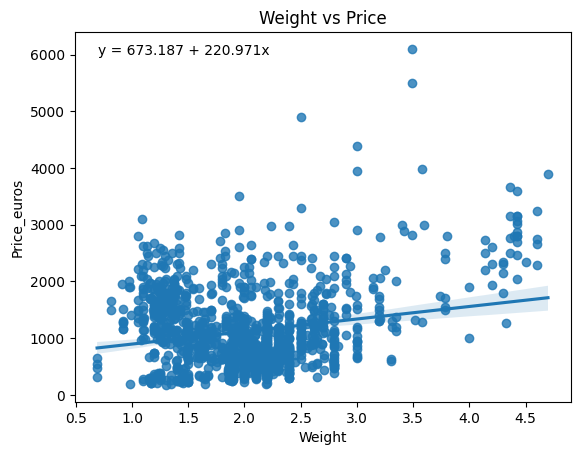

<Figure size 640x480 with 0 Axes>

In [ ]:
import scipy
p = sns.regplot(data=laptop, x=laptop.Weight, y=laptop.Price_euros)

#calculate slope and intercept
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

plt.text(0.7, 6000, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')
plt.title("Weight vs Price")
plt.figure()


On the plot above we see that there is a slight positive correlation between the weight and the price of a laptop.

Text(1, 6000, 'y = -241.84 + 594.025x')

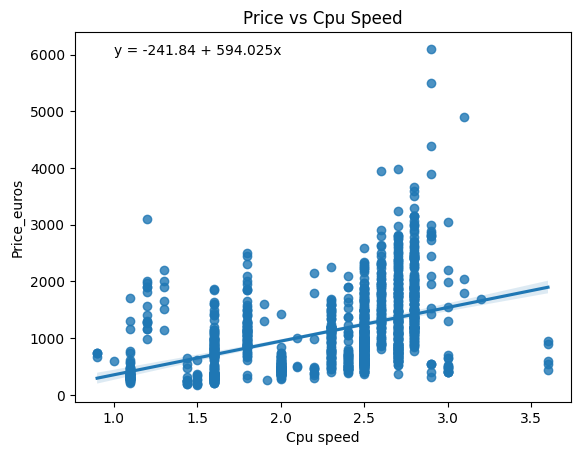

In [ ]:
p = sns.regplot(data=laptop, x=laptop['Cpu speed'], y=laptop.Price_euros)

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())
plt.title("Price vs Cpu Speed")
plt.text(1, 6000, 'y = ' + str(round(intercept,3)) + ' + ' + str(round(slope,3)) + 'x')

We see that there is a slight positive correlation between Cpu speed and price of a laptop. It is estimated that an increase in cpu speed in 1 GHz is correlated to 594 euro increase in price.

## Feature Scaling

### Dealing with Nans

In [ ]:
laptop["Memory1 size"].isna().sum() #screen type, touch screen, memory2 type, size

0

There are several columns containing ~900 and more NaN values, which OneHotEncoder cannot handle. Most popular ways of handling NaNs are using Sklearn's SimpleImputer unit or dropping the columns alltogether. However, we know the reasion we have NaNs in touch screen, memory2 type, and memory2 size columns is because some laptops do not have a touch screen or a second memory drive. So, we can substitute the NaNs with "no" and "0" (for the size column). I will drop the "screen type" column.

In [4]:
laptop[['Touchscreen', 'Memory2 type']] = laptop[['Touchscreen', 'Memory2 type']].fillna('no')
laptop["Memory2 size"] = laptop["Memory2 size"].fillna(0)

In [5]:
laptop = laptop.drop(["Screen type"], axis = 1)

### x, y split

Before feature scaling and one hot encoding, I am dividing the dataset into two: X and y. X contains all the independent variables that can have an effect on the dependent variable y. In our case, we want to understand how laptop attributes influence laptop's price. Hence, y is the "Price_euros" column, and X contains everything else from our clean dataset.

In [6]:
# dividing into indepedent and dependent datasets
X, y = laptop.drop(["Price_euros"], axis = 1), laptop["Price_euros"]
X.head(10)

,Company,Product,TypeName,Inches,Cpu type,Ram,Memory1 type,Gpu type,OpSys,Weight,Resolution,Touchscreen,Cpu speed,Memory2 type,Memory2 size,Memory1 size
0,apple,macbook pro,ultrabook,13.3,intel,8,ssd,intel,macos,1.37,2560x1600,no,2.3,no,0.0,128.0
1,apple,macbook air,ultrabook,13.3,intel,8,flash storage,intel,macos,1.34,1440x900,no,1.8,no,0.0,128.0
2,hp,250 g6,notebook,15.6,intel,8,ssd,intel,no os,1.86,1920x1080,no,2.5,no,0.0,256.0
3,apple,macbook pro,ultrabook,15.4,intel,16,ssd,amd,macos,1.83,2880x1800,no,2.7,no,0.0,512.0
4,apple,macbook pro,ultrabook,13.3,intel,8,ssd,intel,macos,1.37,2560x1600,no,3.1,no,0.0,256.0
5,acer,aspire 3,notebook,15.6,amd,4,hdd,amd,windows 10,2.10,1366x768,no,3.0,no,0.0,500.0
6,apple,macbook pro,ultrabook,15.4,intel,16,flash storage,intel,mac os x,2.04,2880x1800,no,2.2,no,0.0,256.0
7,apple,macbook air,ultrabook,13.3,intel,8,flash storage,intel,macos,1.34,1440x900,no,1.8,no,0.0,256.0
8,asus,zenbook ux430un,ultrabook,14.0,intel,16,ssd,nvidia,windows 10,1.30,1920x1080,no,1.8,no,0.0,512.0
9,acer,swift 3,ultrabook,14.0,intel,8,ssd,intel,windows 10,1.60,1920x1080,no,1.6,no,0.0,256.0


In [ ]:
# checking the data types
X.dtypes

Company          object
Product          object
TypeName         object
Inches          float64
Cpu type         object
Ram               int64
Memory1 type     object
Gpu type         object
OpSys            object
Weight          float64
Resolution       object
Touchscreen      object
Cpu speed       float64
Memory2 type     object
Memory2 size    float64
Memory1 size    float64
dtype: object

### Train & Test split
We want our model to be able to accurately estimate a newlaptop's price based on certain characteristics, even if the model has not seen this particular set of characteristics before. So, in order to assess this ability, we will preserve 20% of the dataset for testing our model, that is assessing how well or poorly it performs on "new" data, and how able it is to apply its knowledge from teh training dataset to unseen data.

In [7]:
# splitting our dataset
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Below I am rescaling and numericaly encoding the specified columns so that our model can process the information (eg. normalizing)

In [8]:
# scaling to 0-1 range
# representing string columns as sparse vectors
ct = make_column_transformer(
    (MinMaxScaler(), ["Inches", "Ram", "Weight", "Cpu speed", "Memory2 size", "Memory1 size"]),
    (OneHotEncoder(handle_unknown = "ignore"),
     ["Company", "Product","TypeName", "Cpu type","Memory1 type", "Gpu type",
      "OpSys", "Resolution", "Touchscreen","Memory2 type"])
)

ct.fit(x_train)
x_train_normal = ct.transform(x_train)
x_test_normal = ct.transform(x_test)

## Creating, testing and evaluation the random forest model

### Model 1

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth = 10, random_state = 32, n_estimators = 10)

random_forest.fit(x_train_normal, y_train)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=32)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = random_forest.predict(x_test_normal)
rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("R-squared training:", float(format(random_forest.score(x_train_normal, y_train), '.3f')))
print("R-squared testing:", float(format(random_forest.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse)

R-squared training: 0.936
R-squared testing: 0.817

RMSE:  304.889


We see that the model is overfitting a little, meaning it learns the training data well, however, fails to generalize it for the testing data. Let's create another model with slightly different hyperparameters to compare the results.

### Model 2

In [ ]:
model_2 = RandomForestRegressor(max_depth = 5, random_state = 32, n_estimators = 10)

model_2.fit(x_train_normal, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=32)

In [ ]:
y_pred_2 = model_2.predict(x_test_normal)
rmse_2 = float(format(np.sqrt(mean_squared_error(y_test, y_pred_2)), '.3f'))
print("R-squared training:", float(format(model_2.score(x_train_normal, y_train), '.3f')))
print("R-squared testing:", float(format(model_2.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse_2)

R-squared training: 0.82
R-squared testing: 0.778

RMSE:  335.592


Now the model performs even worse and overfitting persists. Let's try again.

### Model 3

In [ ]:
model_3 = RandomForestRegressor(max_depth = 10, random_state = 32, n_estimators = 50)
model_3.fit(x_train_normal, y_train)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=32)

In [ ]:
y_pred_3 = model_3.predict(x_test_normal)
rmse_3 = float(format(np.sqrt(mean_squared_error(y_test, y_pred_3)), '.3f'))
print("R-squared (training):", float(format(model_3.score(x_train_normal, y_train), '.3f')))
print("R-squared (testing):", float(format(model_3.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse_3)

R-squared (training): 0.941
R-squared (testing): 0.827
RMSE: 296.193


### Model 4

In [ ]:
model_4 = RandomForestRegressor(max_depth = 20, random_state = 32, n_estimators = 100)
model_4.fit(x_train_normal, y_train)

RandomForestRegressor(max_depth=20, random_state=32)

In [ ]:
y_pred_4 = model_4.predict(x_test_normal)
rmse_4 = float(format(np.sqrt(mean_squared_error(y_test, y_pred_4)), '.3f'))
print("R-squared (training):", float(format(model_4.score(x_train_normal, y_train), '.3f')))
print("R-squared (testing):", float(format(model_4.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse_4)

R-squared (training): 0.972
R-squared (testing): 0.828
RMSE: 295.736


### Model 5

In [75]:
model_5 = RandomForestRegressor(random_state = 32, n_estimators = 100, max_features = 15)
model_5.fit(x_train_normal, y_train)

RandomForestRegressor(max_features=15, random_state=32)

In [76]:
y_pred_5 = model_5.predict(x_test_normal)
rmse_5 = float(format(np.sqrt(mean_squared_error(y_test, y_pred_5)), '.3f'))
print("R-squared (training):", float(format(model_5.score(x_train_normal, y_train), '.3f')))
print("R-squared (testing):", float(format(model_5.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse_5)

R-squared (training): 0.976
R-squared (testing): 0.837
RMSE: 287.927


Model 5 has the best training and testing R-square value so far. I will use this model, hwoever, will try to reduce the gap in accuracy between the training and testing data.

### Model 6

In [113]:
model_6 = RandomForestRegressor(random_state = 32, n_estimators = 100, max_features = 70)
model_6.fit(x_train_normal, y_train)

RandomForestRegressor(max_features=70, random_state=32)

In [114]:
y_pred_6 = model_6.predict(x_test_normal)
rmse_6 = float(format(np.sqrt(mean_squared_error(y_test, y_pred_6)), '.3f'))
print("R-squared (training):", float(format(model_6.score(x_train_normal, y_train), '.3f')))
print("R-squared (testing):", float(format(model_6.score(x_test_normal, y_test), '.3f')))
print("RMSE:", rmse_6)

R-squared (training): 0.977
R-squared (testing): 0.844
RMSE: 281.75


While model 6 did not reduce the gap between R-squared values for training and testing data, it outperformed all the previous models in every metric.

## Creating, testing and evaluating regression neural network


In [10]:
# converting to numpy so that TensorFlow can process the data
x_test_normal = x_test_normal.toarray()
x_train_normal = x_train_normal.toarray()

### Model 1

Below I am creating a three layer model (with 100, 10 and 1 neurons). To calculate the model error, I am using MAE (Mean Absolute Error), which computes how far off the model predicts the prices on average as compared to the actual prices.

In [41]:
# setting random seed for reproduction
tf.random.set_seed(42)

laptop_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

laptop_model1.compile(loss = "mse",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = [tf.keras.metrics.RootMeanSquaredError()])

# fitting on the normalized train data
history = laptop_model1.fit(x_train_normal,
                            y_train,
                            epochs = 300,
                            validation_data = (x_test_normal, y_test),
                            verbose = 0)

In [13]:
laptop_model1.evaluate(x_train_normal, y_train)

33/33 [==============================] - 0s 5ms/step - loss: 24385.4395 - root_mean_squared_error: 156.1584


[24385.439453125, 156.1583709716797]

In [12]:
# evaluating the model on the test data
laptop_model1.evaluate(x_test_normal, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 98993.3516 - root_mean_squared_error: 314.6321


[98993.3515625, 314.632080078125]

Above, we can see that the model's performance decreased by 50% on the test data. On the train data, the model's RMSE is ~ 156, while on the test data it is ~315! This means the model might be overfitting.

<Axes: >

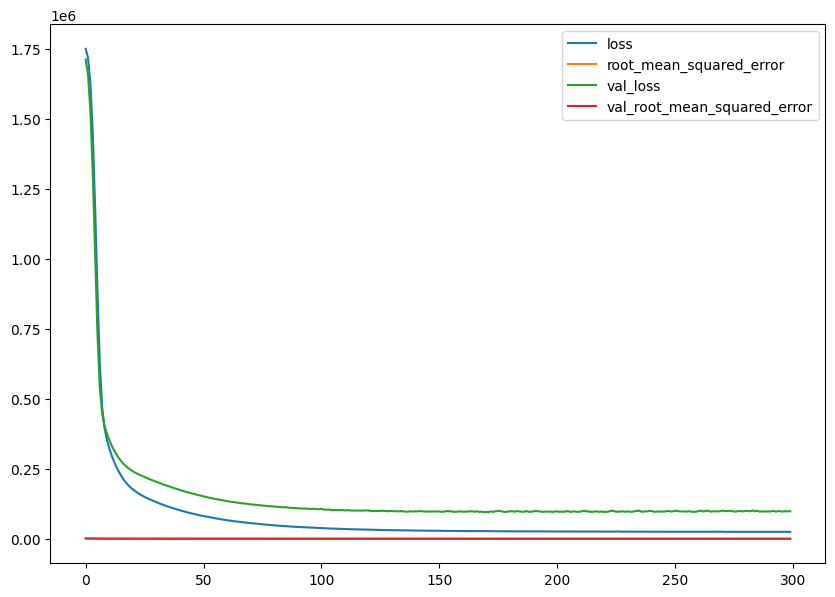

In [42]:
pd.DataFrame(history.history).plot(figsize = (10, 7))

On the plot above, we can see that both the training and testing loss decreases. Training loss does not increase over time, which means we might not be overfitting after all.

### Model 2

In [61]:
tf.random.set_seed(42)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

nn_model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(140, activation = "linear"),
    tf.keras.layers.Dense(400, activation = "linear"),
    tf.keras.layers.Dense(260, activation = "linear"),
    tf.keras.layers.Dense(30, activation = "linear"),
    tf.keras.layers.Dense(1, activation = "linear")
])

nn_model_2.compile(loss = "mse",
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = [tf.keras.metrics.RootMeanSquaredError()])

history_2 = nn_model_2.fit(x_train_normal,
                           y_train,
                           validation_data = (x_test_normal, y_test),
                           epochs = 300,
                           callbacks = [es_callback],
                           verbose = 0)

In [62]:
nn_model_2.evaluate(x_test_normal, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 96836.6484 - root_mean_squared_error: 311.1859


[96836.6484375, 311.1858825683594]

<Axes: >

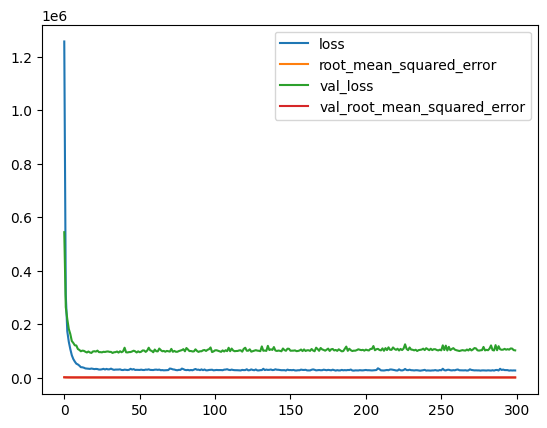

In [60]:
pd.DataFrame(history_2.history).plot()

While model_2 performs a little bit better than the previous model, it does not outperform the random forest model 6. Our final neural network regression has RMSE of 311, while final random forest model has that of ~281.